In [17]:
import numpy as np 
import pandas as pd 
import statistics
import os 
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import math 

In [18]:
features=['flow', 'aum', 'dividend_yield', 'exp_ratio_net', 'fee_rate',
                       'turnover_ratio',
                       'st_reversal', 'st_momentum', 'momentum', 'int_momentum', 'lt_momentum', 'lt_reversal',
                       'age', 'R_squared', 'fund_st_reversal', 'fund_st_momentum', 'fund_momentum', 'family_flow',
                       'family_aum', 'family_age', 'family_fund_momentum', 'no_funds']
data_dir = 'sensitivity_20240922'

In [19]:
def get_normalized_sensitivity(features, df):
    '''filter features and normalilze sensitivity
    '''
    #normalize by total sens 
    #sensitivity_sum = df['0'].sum()
    #normalize by group
    sensitivities = []
    normalized_sensitivities = []
    for i in range(len(features)):
        feature = features[i]
        row = df[df['Unnamed: 0']==feature]
        if not row.empty:
            sens = row['0'].values[0]
            sensitivities.append(sens)
            #normalized_sensitivities.append(sens/sensitivity_sum)
        else: 
            raise ValueError(f'feauture not found: {feature}')
    sensitivity_sum = np.sum(sensitivities)
    for i in range(len(features)):
        normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
    return pd.DataFrame({
        "features": features,
        "sensitivity_normalized": normalized_sensitivities
    })
def plot_box_chart(features, medians, lower_percentiles, upper_percentiles, targets=None, order = None, title='', save=False, colors = None):
        if not order:
            order = np.argsort(medians)[::-1]
        features = [features[i] for i in order] 
        medians = [medians[i]*100 for i in order] 
        lower_percentiles = [lower_percentiles[i]*100 for i in order] 
        upper_percentiles = [upper_percentiles[i]*100 for i in order] 
        lower_errors = [mean - lower for mean, lower in zip(medians, lower_percentiles)]
        upper_errors = [upper - mean for mean, upper in zip(medians, upper_percentiles)]
        plt.figure(figsize=(15,15))
        if colors: 
            bar_plot = plt.barh(features, medians, xerr=[lower_errors, upper_errors], capsize=5, color=colors)
        else:
            bar_plot = plt.barh(features, medians, xerr=[lower_errors, upper_errors], capsize=5)
        if targets: 
            for i, bar in enumerate(bar_plot):
                plt.scatter(targets[i], bar.get_y() + bar.get_height()/2, color='red', marker='o', zorder=5)
        plt.xlabel('Sensitivity')
        plt.title('Sensitivity Box Chart '+title)
        plt.gca().invert_yaxis()
        if save:
            plt.savefig("individual_variable_box_chart{}.png".format(title), dpi=300, bbox_inches='tight')
        plt.show()
def plot_sensitivity_with_boostrap(M, N, features, dirname='sensitivity_bond/', normalize=True, graph=True):
    #read all files
    files = os.listdir(dirname)
    files = [_ for _ in files if "sensitivity_" in _]
    df_main = pd.DataFrame()
    name_dict = {}
    invalid_num =0 
    #get all sensitivity numbers
    for file_ind in tqdm(range(len(files))):
        file = files[file_ind]
        if normalize:
            df_temp = pd.read_csv(dirname + file)
            #df_temp = saved_files[file].reset_index()
            df = get_normalized_sensitivity(features, df_temp)
            if df.isna().any().any():
                invalid_num += 1
                continue
            df.set_index('features', inplace=True)
        else:
            #df = pd.read_csv(dirname + file, index_col=0)
            df = pd.read_csv(dirname + file)
            #df = saved_files[file]
            df = df.loc[df['Unnamed: 0'].isin(features)][['Unnamed: 0', '0']]
            df.set_index('Unnamed: 0', inplace=True)
            #print(df.head())
            #df['0'] = df['0']*100
        df.columns = [file_ind]
        name_dict[file_ind] = file
        df_main = pd.concat([df_main, df], axis=1)
    df_array = df_main.to_numpy()
    #boostrap process
    inds = np.random.choice(range(len(files)-invalid_num), size=(M, N))
    vals = np.mean(df_array[:, inds], axis=1) #take mean across M models
    p75 = np.percentile(vals, 75, axis=1) 
    p25 = np.percentile(vals, 25, axis=1) 
    median = np.median(vals, axis=1) 
    if graph:
        plot_box_chart(features, median, p25, p75, title=f'N{N}M{M}')
    ########
    num = (p75 - p25 )/median
    ########
    return name_dict, num

  5%|▍         | 66/1356 [00:00<00:03, 324.61it/s]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_17655/3951118280.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
 15%|█▌        | 205/1356 [00:00<00:03, 342.84it/s]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_17655/3951118280.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
 29%|██▊       | 387/1356 [00:01<00:02, 352.96it/s]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_17655/3951118280.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_17655/3951118280.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
 37%|███

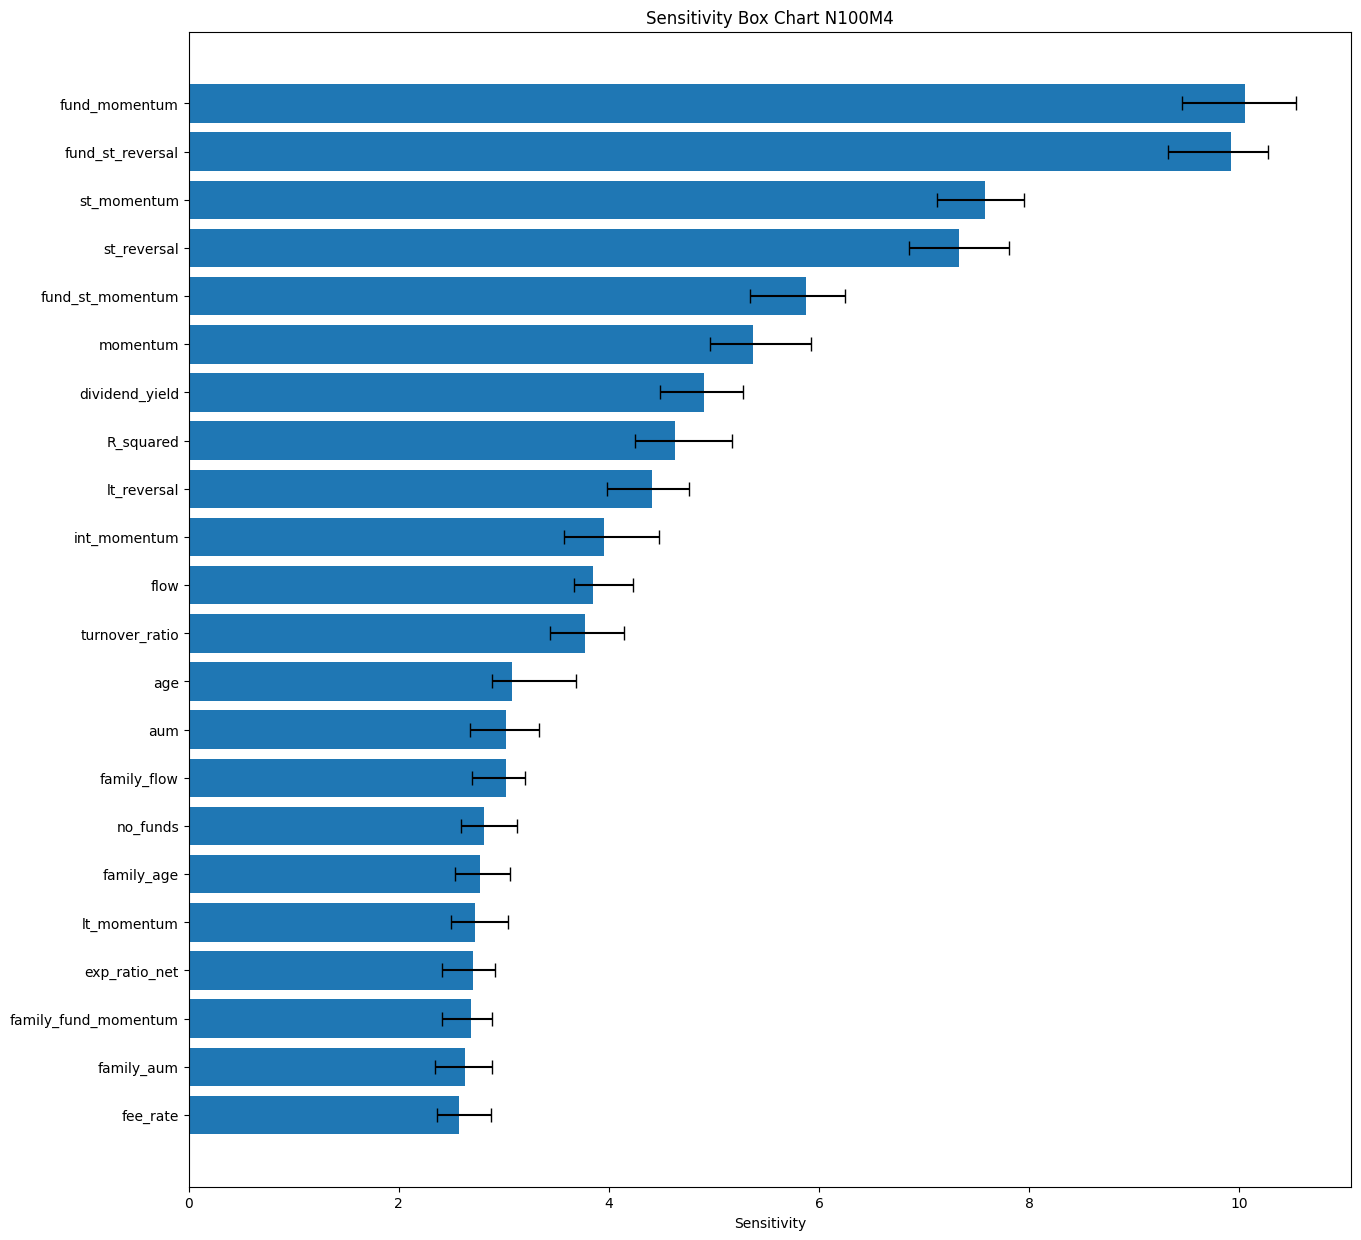

({0: 'sensitivity_1727053059984.csv',
  1: 'sensitivity_1727049356966.csv',
  2: 'sensitivity_1727053235164.csv',
  3: 'sensitivity_1727050366078.csv',
  4: 'sensitivity_1727051738964.csv',
  5: 'sensitivity_1727048606043.csv',
  6: 'sensitivity_1727053470111.csv',
  7: 'sensitivity_1727049657131.csv',
  8: 'sensitivity_1727051074060.csv',
  9: 'sensitivity_1727052918055.csv',
  10: 'sensitivity_1727052194163.csv',
  11: 'sensitivity_1727049468153.csv',
  12: 'sensitivity_1727051081980.csv',
  13: 'sensitivity_1727049939965.csv',
  14: 'sensitivity_1727053181109.csv',
  15: 'sensitivity_1727053086114.csv',
  16: 'sensitivity_1727050985055.csv',
  17: 'sensitivity_1727051496010.csv',
  18: 'sensitivity_1727051036051.csv',
  19: 'sensitivity_1727052622061.csv',
  20: 'sensitivity_1727052282020.csv',
  21: 'sensitivity_1727048776003.csv',
  22: 'sensitivity_1727051744059.csv',
  23: 'sensitivity_1727052376994.csv',
  24: 'sensitivity_1727048270054.csv',
  25: 'sensitivity_1727051283040.cs

In [20]:
plot_sensitivity_with_boostrap(M=4, N=100, features=features, dirname=data_dir+'/', normalize = True)

In [21]:
def plot_sensitivity_trend(savepath=None):
    #plot sensitivity trend for each feature 
    feature_trends = []
    for feature_idx in tqdm(range(len(feature_names))):
        curr_future = [feature_names[feature_idx]]
        nums = []
        for M in [2**n for n in range(1, 11)]:
            name_dict, num = plot_sensitivity_with_boostrap(M, 10000, curr_future, dirname='sensitivity_bond_20240908/', normalize=False, graph=False)
            nums.append(num[0])
        feature_trends.append(nums)
    plt.figure()
    for i in tqdm(range(len(feature_trends))):
        plt.plot(range(1, 11), feature_trends[i], label = f'{feature_names[i]}')
    plt.xlabel('M values')
    plt.ylabel('(75th - 25th)/median')
    plt.legend(loc='upper right', fontsize=7, borderpad=0.5, labelspacing=0.3)
    if savepath is not None:
        plt.savefig()
    plt.show()

In [22]:
#function to normalize macro variables 
def get_macro_std_merge(macrodir, preddir):
    macro_df = pd.read_csv(macrodir).sort_values(by=['Month']).reset_index()
    pred_df = pd.read_csv(preddir)
    df_merged = pd.merge(pred_df, macro_df, how='inner', on='Month')
    macro_names = list(macro_df.columns)[2:]
    macro_std = {}
    for macroname in macro_names:
        std = np.std(df_merged[macroname])
        macro_std[macroname] = std
    return macro_std
def get_macro_std_no_merge(macrodir):
    macro_df = pd.read_csv(macrodir).sort_values(by=['Month']).reset_index()
    macro_names = list(macro_df.columns)[2:]
    macro_std = {}
    for macroname in macro_names:
        macro_std[macroname] = np.std(macro_df[macroname].values)
    return macro_std
def normalize_macro(df, macro_std):
    for macroname, std in macro_std.items():
        try: 
            df.loc[df['Unnamed: 0'] == macroname, '0'] = df.loc[df['Unnamed: 0']==macroname]['0'].values[0]/std * (1/math.sqrt(12))
            #df.loc[df['Unnamed: 0'] == macroname, '0'] = df.loc[df['Unnamed: 0']==macroname]['0'].values[0]/std 
        except IndexError:
            print(macroname)
    return df
def normalize_all_csv(dirname, macro_std):
    files = os.listdir(dirname)
    files = [_ for _ in files if "sensitivity_" in _]
    for file_ind in tqdm(range(len(files))):
        filepath  = os.path.join(dirname, files[file_ind])
        try:
            df = normalize_macro(pd.read_csv(filepath), macro_std)
        except IndexError as e:
            print("error", filepath, "e", e)
        df.to_csv(filepath)
'''
#normalize all files 
macro_std = get_macro_std_no_merge('bond_fund_macro.csv')
#macro_std = get_macro_std_merge('bond_fund_macro.csv', 'pred_1726451985958.xz')
print(macro_std)
normalize_all_csv(dirname='/Users/elvisyan/Downloads/sensitivity_bond_20240916', macro_std=macro_std)
plot_sensitivity_with_boostrap(M=512, N=10000, features=macro_vars, dirname='/Users/elvisyan/Downloads/sensitivity_bond_20240916/', normalize = False)
plot_sensitivity_with_boostrap(M=512, N=10000, features=feature_names, dirname='/Users/elvisyan/Downloads/sensitivity_bond_20240916/', normalize = False)
'''

"\n#normalize all files \nmacro_std = get_macro_std_no_merge('bond_fund_macro.csv')\n#macro_std = get_macro_std_merge('bond_fund_macro.csv', 'pred_1726451985958.xz')\nprint(macro_std)\nnormalize_all_csv(dirname='/Users/elvisyan/Downloads/sensitivity_bond_20240916', macro_std=macro_std)\nplot_sensitivity_with_boostrap(M=512, N=10000, features=macro_vars, dirname='/Users/elvisyan/Downloads/sensitivity_bond_20240916/', normalize = False)\nplot_sensitivity_with_boostrap(M=512, N=10000, features=feature_names, dirname='/Users/elvisyan/Downloads/sensitivity_bond_20240916/', normalize = False)\n"